# FORMATIVE ASSIGNMENT II: WATER QUALITY MODEL

## 1. Introduction
**Assignment**: Building a Classification Model Using Neural Networks

**Objective:**
Develop a neural network-based classification model using a provided dataset, incorporating multiple optimization techniques and ensuring equitable group contribution.

**In this notebook, we will take the cleaned and imputed dataset and use it to train, test, and evaluate a deep learning model**:

The key steps we'll cover are:
1. Loading the preprocessed (imputed) dataset.
2. Separating features and the target variable.
3. Splitting the dataset into three distinct portions: training, validation, and testing sets. This is crucial for robust model development and evaluation.
4. Applying feature scaling (StandardScaler) correctly after the split to prevent data leakage.

**Note:** The data cleaning and imputation steps were performed in a previous notebook. 
If you'd like to review that process, please refer to: [Data Preprocessing Notebook](data_preprocessing.ipynb).

**Model Details**


| Engineer Name     | Regularizer | Optimizer | Early Stopping  | Dropout Rate | Learning Rate |
| ----------------- | ---------------------------- | --------- | ------------------------------------------------ | ------------ | ------------- |
| Akoto-Nimoh Christine|L1_L2 (l1=any_number, l2=any_number) | SGD (Nesterov) | Disabled (Fixed epochs = any_number) |0.25| 0.01|



In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1L2
import numpy as np
import os
import pandas as pd
import seaborn as sns

### 1.1 Going through the data imputed data


In [2]:

data = pd.read_csv('../data/imputed_water_potability_data.csv')


In [3]:
print("Data shape:", data.shape)

Data shape: (3276, 10)


In [4]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.036752,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.073546,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.073546,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
data['Potability'].value_counts()

Potability
0    1998
1    1278
Name: count, dtype: int64

<Axes: >

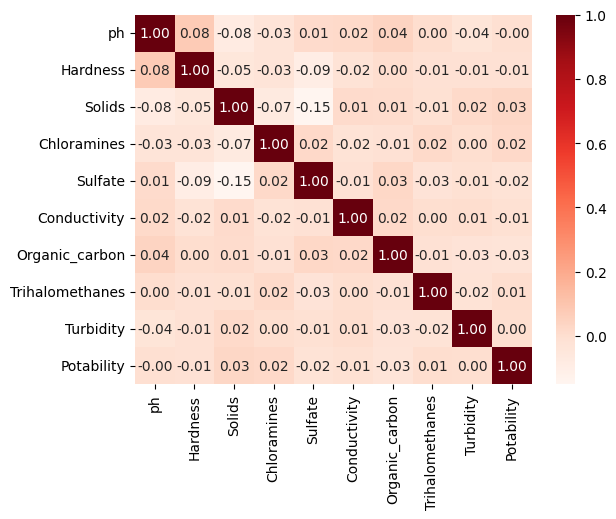

In [6]:
sns.heatmap(data.corr(), annot= True , cmap='Reds', fmt='.2f')

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def preprocess_data_with_validation(data, test_size=0.2, val_size=0.1, random_state=42):
    # Separate features and target
    X = data.drop('Potability', axis=1)
    y = data['Potability']

    # First split: training + temp (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size + val_size, random_state=random_state
    )

    # Calculate adjusted validation size relative to X_temp
    val_ratio = val_size / (test_size + val_size)

    # Second split: validation + test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=1 - val_ratio, random_state=random_state
    )

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test


### Building the model

In [10]:
from tensorflow.keras import models, layers, optimizers, regularizers
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = preprocess_data_with_validation(data)

def build_model(input_shape, l1=0.01, l2=0.01, dropout_rate=0.25, learning_rate=0.01):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,),
                     kernel_regularizer= regularizers.l1_l2(l1=l1, l2=l2)),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu'),
        layers.Dense(2, activation='softmax')  # 2 output units for binary classification (one-hot style)
    ])

    sgd = optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

    model.compile(optimizer=sgd,
                  loss='sparse_categorical_crossentropy',  # sparse if y is integers (0,1)
                  metrics=['accuracy'])
    return model


In [11]:
from tensorflow.keras import models, layers, optimizers, regularizers
model = build_model(input_shape=X_train_scaled.shape[1], l1=0.001, l2=0.001, learning_rate=0.01)
model.summary()

c:\Users\Hp\water-quality-model\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,786 (10.88 KB)

 Trainable params: 2,786 (10.88 KB)

 Non-trainable params: 0 (0.00 B)

## training 

In [13]:
def train_model(model, X_train, y_train, epochs=100, batch_size=32):
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_split=0.25  # from your parameters
    )
    return history
history = train_model(model, X_train_scaled, y_train, epochs=50, batch_size=32)




Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5485 - loss: 0.8039 - val_accuracy: 0.6063 - val_loss: 0.7633
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6272 - loss: 0.7454 - val_accuracy: 0.6481 - val_loss: 0.7436
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6255 - loss: 0.7463 - val_accuracy: 0.6237 - val_loss: 0.7344
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6333 - loss: 0.7215 - val_accuracy: 0.6603 - val_loss: 0.7164
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6642 - loss: 0.7047 - val_accuracy: 0.6794 - val_loss: 0.7026
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6577 - loss: 0.7023 - val_accuracy: 0.6638 - val_loss: 0.7016
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6572 - loss: 0.7024 - val_accuracy: 0.6864 - val_loss: 0.6872
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6587 - loss: 0.6883 - val_accuracy: 0.6742 - val_loss:

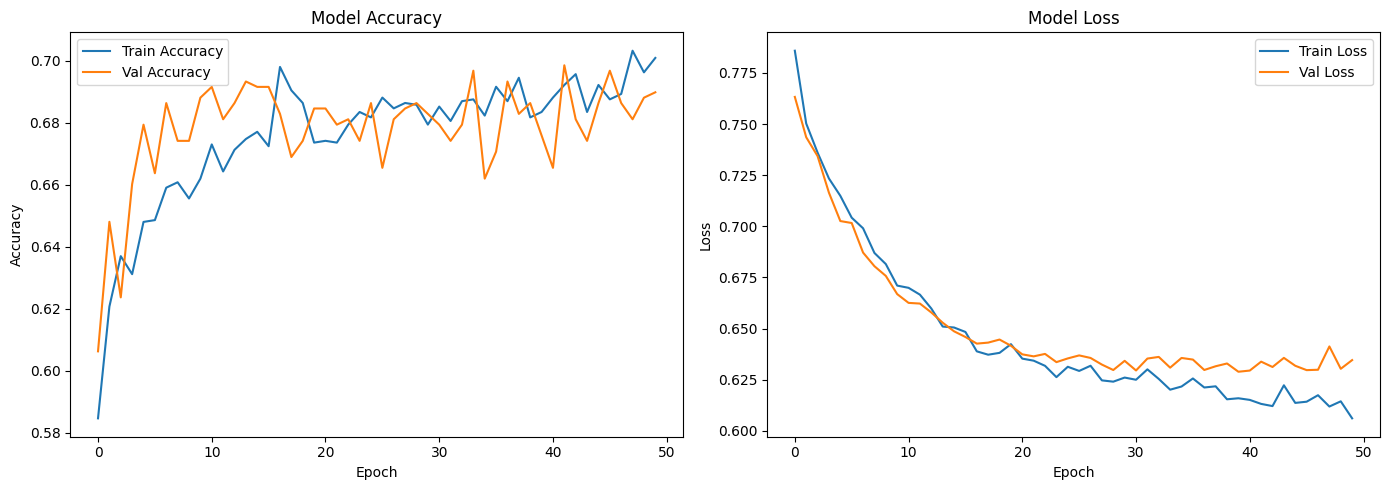

In [14]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , classification_report
def evaluate_model(model, X_test, y_test):
    results = model.evaluate(X_test, y_test, verbose=1)
    print(f"\nTest Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1] * 100:.2f}%")

    # Predictions & confusion matrix
    y_pred = model.predict(X_test)
    y_classes = np.argmax(y_pred, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_classes))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_classes))
evaluate_model(model, X_test_scaled, y_test)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6967 - loss: 0.6210 

Test Loss: 0.6274
Test Accuracy: 70.58%
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80       417
           1       0.69      0.35      0.46       239

    accuracy                           0.71       656
   macro avg       0.70      0.63      0.63       656
weighted avg       0.70      0.71      0.68       656

Confusion Matrix:
[[380  37]
 [156  83]]


## Report

###  Model Configuration Details

####  **Model Type**
**Neural Network (MLP)**  
Chosen for its flexibility to model nonlinear relationships in the data.

---

####  **Regularizer(s) & Strength(s)**
**L1 and L2 Regularization**  
- **L1:** `any_number`  
- **L2:** `any_number`

Regularization was applied to reduce overfitting by penalizing large weights.  
- **L1** encourages sparsity in the weights.  
- **L2** promotes weight decay.  
Together, they help improve generalization.

---

#### ⚙️ **Optimizer**
**SGD with Nesterov Momentum**  
Selected to benefit from:
- Accelerated convergence  
- Stable updates  
- Avoidance of local minima  
- Improved training dynamics

---

####  **Early Stopping**
**Disabled** (Fixed epochs = `any_number`)  
Training was allowed to run for all epochs to fully assess convergence.

---

####  **Dropout Rate**
**0.25**  
A 25% dropout rate was applied to:
- Prevent co-adaptation of neurons  
- Reduce overfitting  
- Encourage robust feature learning

---

####  **Learning Rate**
**0.01**  
Chosen as a standard baseline for SGD, balancing:
- Training speed  
- Stability of convergence


###  Metric Evaluation Summary

####  **Accuracy**: 69.66%  
**Interpretation**: *Good* — The model correctly predicts nearly 70% of cases, indicating reasonable overall performance.

####  **F1 Score (Class 1)**: 0.46  
**Interpretation**: *Moderate* — The low F1 score for the positive class suggests the model struggles to balance precision and recall, likely due to class imbalance.

####  **Recall (Class 1)**: 0.35  
**Interpretation**: *Poor* — The model misses many actual positive cases, which limits its ability to detect all relevant instances (low sensitivity).

####  **Precision (Class 1)**: 0.68  
**Interpretation**: *Fair* — When the model predicts a positive, it's often correct. However, this high precision comes at the cost of missing many true positives.


### 3.1. Comparison with Teammate A (MLP with Adam Optimizer)

🔍 **Metric Comparison** (With Jean Paul Ikaroze Model)

| Metric              | My Model (MLP + SGD) | Teammate A (MLP + Adam) | Detailed Analysis                                                                 |
|---------------------|----------------------|--------------------------|------------------------------------------------------------------------------------|
| F1 Score (Class 1)  | 0.46                 | 0.48                     | Teammate A’s model slightly outperformed mine in balancing precision and recall.   |
| Recall (Class 1)    | 0.35                 | 0.36                     | Both models performed poorly; A’s model caught slightly more potable samples.      |
| Precision (Class 1) | 0.68                 | 0.70                     | Teammate A had marginally better precision, meaning more reliable positives.       |
| Accuracy            | 69.66%               | 69.00%                   | Accuracy was similar, but less meaningful due to class imbalance.                  |


### 3.2. Comparison with Teammate B (MLP + RMSprop Optimizer)

 **Metric Comparison** Nicholas Nke

| Metric              | My Model (MLP + SGD) | Teammate B (MLP + RMSprop) | Detailed Analysis                                                                 |
|---------------------|----------------------|------------------------------|------------------------------------------------------------------------------------|
| F1 Score (Class 1)  | 0.46                 | 0.00                         | My model captured the trade-off between precision and recall. B’s model entirely failed to classify potable water. |
| Recall (Class 1)    | 0.35                 | 0.00                         | My model correctly identified 35% of potable samples; B’s model missed every one. |
| Accuracy            | 69.66%               | 60.98%                       | B’s accuracy reflects majority-class bias. My model showed better class separation. |
